In [29]:
import pandas as pd
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [30]:
# Load cleaned data with timestamp
cleaned_data_path = 'cleaned_data/solar_data_january_1min_2023_timestamp.csv'
df = pd.read_csv(cleaned_data_path, sep=';')

In [31]:
# Extract features and target
X = df['Timestamp'].values.reshape(-1, 1)
y = df[['Azimuth', 'Altitude']].values

In [32]:
# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [33]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).view(-1, 1, 1)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)


In [34]:
# Move tensors to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_tensor, y_tensor = X_tensor.to(device), y_tensor.to(device)

In [35]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [36]:
# Define the RNN-LSTM model
class RNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNLSTMModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [37]:
# Instantiate the model
input_size = 1
hidden_size = 512
num_layers = 2
output_size = 2
model = RNNLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [38]:
# Training loop
num_epochs = 1000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)

    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 10/1000, Loss: 0.3478546142578125, Val Loss: 0.3439628779888153
Epoch 20/1000, Loss: 0.3310493528842926, Val Loss: 0.32715097069740295
Epoch 30/1000, Loss: 0.3130491375923157, Val Loss: 0.30905985832214355
Epoch 40/1000, Loss: 0.2929997742176056, Val Loss: 0.28886616230010986
Epoch 50/1000, Loss: 0.27033111453056335, Val Loss: 0.266041100025177
Epoch 60/1000, Loss: 0.24491630494594574, Val Loss: 0.24052026867866516
Epoch 70/1000, Loss: 0.21733996272087097, Val Loss: 0.2129790037870407
Epoch 80/1000, Loss: 0.18919770419597626, Val Loss: 0.18512387573719025
Epoch 90/1000, Loss: 0.16322273015975952, Val Loss: 0.15978071093559265
Epoch 100/1000, Loss: 0.1428316831588745, Val Loss: 0.14035052061080933
Epoch 110/1000, Loss: 0.13058559596538544, Val Loss: 0.12915685772895813
Epoch 120/1000, Loss: 0.1259787529706955, Val Loss: 0.12529191374778748
Epoch 130/1000, Loss: 0.12532958388328552, Val Loss: 0.12490949034690857
Epoch 140/1000, Loss: 0.12533585727214813, Val Loss: 0.124945379793643

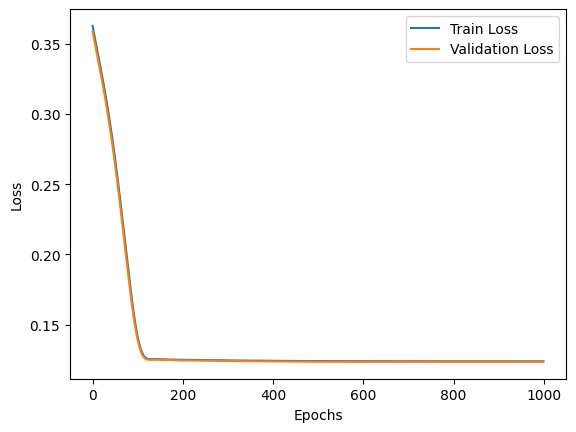

In [39]:
# Plot training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Make predictions on test data
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)

In [41]:
# Inverse transform predictions and actual test data to original scale
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.cpu().numpy())
y_test_actual_inv = scaler_y.inverse_transform(y_test.cpu().numpy())


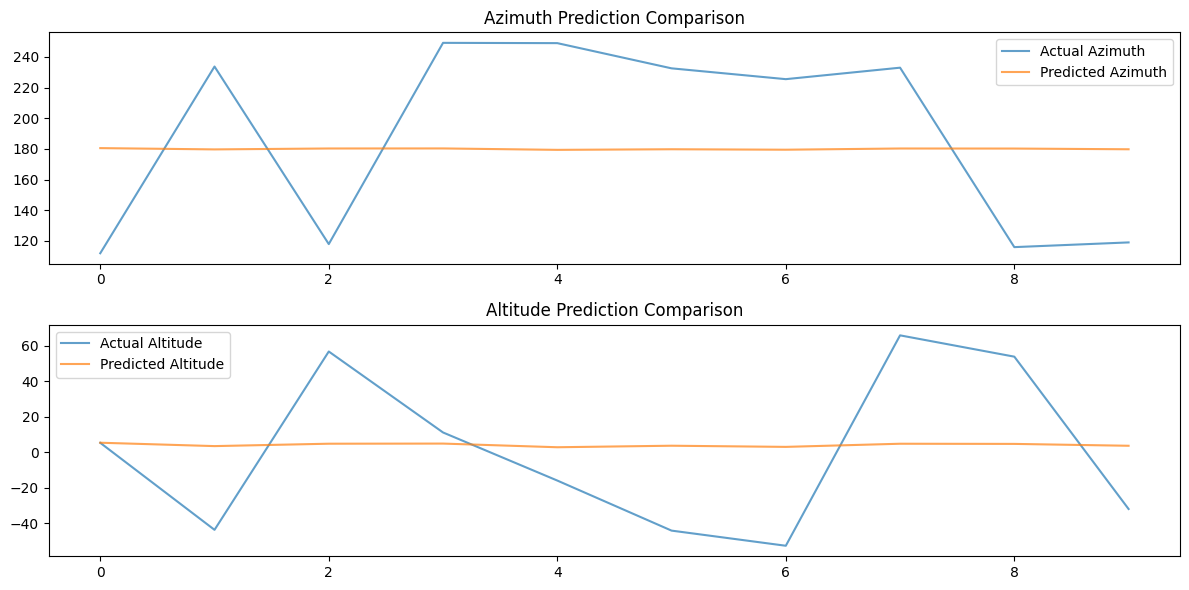

In [42]:
# Plotting the comparison
plt.figure(figsize=(12, 6))

# Azimuth Comparison
plt.subplot(2, 1, 1)
plt.plot(y_test_actual_inv[:10, 0], label='Actual Azimuth', alpha=0.7)
plt.plot(y_test_pred_inv[:10, 0], label='Predicted Azimuth', alpha=0.7)
plt.legend()
plt.title('Azimuth Prediction Comparison')

# Altitude Comparison
plt.subplot(2, 1, 2)
plt.plot(y_test_actual_inv[:10, 1], label='Actual Altitude', alpha=0.7)
plt.plot(y_test_pred_inv[:10, 1], label='Predicted Altitude', alpha=0.7)
plt.legend()
plt.title('Altitude Prediction Comparison')

plt.tight_layout()
plt.show()